## Estimate the rate of CFO from preamble and preamble convolved

Input: Preamble, Preamble convolved with AWGN channel
Output: rate of CFO


Since we can't actually control / measure cfo on real radios, the loss function can only have what we know.

Loss: Preamble - Preamble convolved * CFO correction

In [1]:
# generate data

import numpy as np
import scipy.signal as sig
from numpy import linalg as LA
import matplotlib.pyplot as plt

# Create training and test data for the NN

epochs = 10000
batch_size = 100

snr=50

# number of random preambles that will be trained and tested on
num_train=epochs*batch_size
num_test=batch_size

preamble_length = 50

# QPSK
preamble_train_orig = np.zeros((num_train,preamble_length,2))
preamble_train_cfo = np.zeros((num_train,preamble_length,2))
preamble_test_orig = np.zeros((num_test,preamble_length,2))
preamble_test_cfo = np.zeros((num_test,preamble_length,2))

# the max value the CFO rate can be 
max_omega = 1/50
# the cfo rate is in number of radians turned per sample
omega_train = np.random.uniform(low=0,high=max_omega, size=((num_train,1)))
omega_test = np.random.uniform(low=0,high=max_omega, size=((num_test,1)))


for i in range(num_train):
    # original preamble - known to both TX and RX
    preamble_train_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
    # add AWG noise to the preamble
    if snr > 0:
        preamble_noisy = (1./np.sqrt(snr)) * np.random.randn(preamble_length,2)+preamble_train_orig[i,:,:]
    
    # rotate data according to cfo
    for j in range(preamble_length):
        preamble_train_cfo[i,j,0]=(preamble_noisy[j,0]*np.cos(omega_train[i]*j)
                                       -preamble_noisy[j,1]*np.sin(omega_train[i]*j))
        preamble_train_cfo[i,j,1]=(preamble_noisy[j,0]*np.sin(omega_train[i]*j)
                                      +preamble_noisy[j,1]*np.cos(omega_train[i]*j))
    
    if i % 10000 == 0:
        print(i)
    

for i in range(0, num_test):
    # original preamble - known to both TX and RX
    preamble_test_orig[i,:,:] = ((2*np.random.randint(2,size=(preamble_length,2)))-1)*np.sqrt(2)/2
    # add AWG noise to the preamble
    if snr > 0:
        preamble_noisy = (1./np.sqrt(snr)) * np.random.randn(preamble_length,2)+preamble_test_orig[i,:,:]
    
    # rotate data according to cfo
    for j in range(preamble_length):
        preamble_test_cfo[i,j,0]=(preamble_noisy[j,0]*np.cos(omega_test[i]*j)
                                       -preamble_noisy[j,1]*np.sin(omega_test[i]*j))
        preamble_test_cfo[i,j,1]=(preamble_noisy[j,0]*np.sin(omega_test[i]*j)
                                      +preamble_noisy[j,1]*np.cos(omega_test[i]*j))

print("Data generation complete.")

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
Data generation complete.


In [2]:
# print("Original preamble")
# print(preamble_train_orig[num_train-1,:,:])
# print("Noisy preamble")
# print(preamble_noisy)
# print("CFO preamble")
# print(preamble_train_cfo[num_train-1,:,:])
# print("rate of cfo")
# print(omega_train[num_train-1])


In [8]:
# Feedforward Neural Network to find omega
import tensorflow as tf

# tf.enable_eager_execution()

learning_rate = 0.01

# declare the training data placeholders
preamble_original = tf.placeholder(tf.float32, [None, preamble_length, 2])
preamble_cfo = tf.placeholder(tf.float32, [None, preamble_length, 2])
omega = tf.placeholder(tf.float32, [None,1])

preamble_original_cfo = tf.concat([preamble_original, preamble_cfo], 1)

preamble_original_cfo_flat = tf.contrib.layers.flatten(preamble_original_cfo)

layer_1 = tf.layers.dense(
  preamble_original_cfo_flat, 10, tf.nn.sigmoid, use_bias=True)
layer_2 = tf.layers.dense(
  layer_1, 10, tf.nn.sigmoid, use_bias=True)
layer_3 = tf.layers.dense(
  layer_2, 1, activation=tf.identity, use_bias=True)

est_omega = layer_3

preamble_cfo_complex = tf.complex(preamble_cfo[:,:,0], preamble_cfo[:,:,1])
preamble_cfo_complex = tf.expand_dims(preamble_cfo_complex, -1)

# build the rotation matrix
incremented_omega = []
for i in range(preamble_length):
    incremented_omega.append(-est_omega*i)

rotation_complex = tf.exp(tf.complex(0.0,tf.transpose(incremented_omega, perm=[1,0,2])))
preamble_rotated_complex = tf.multiply(preamble_cfo_complex,rotation_complex)

preamble_rotated = tf.stack([tf.real(preamble_rotated_complex[:,:]), 
                             tf.imag(preamble_rotated_complex[:,:])], axis=2)

preamble_rotated = tf.squeeze(preamble_rotated)

estimation_loss = tf.losses.mean_squared_error(preamble_original, preamble_rotated)

omega_loss = tf.losses.mean_squared_error(est_omega,omega)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(estimation_loss)
                                                                                  
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

Epoch 0, Train Cost 1.015472650527954, Test Cost: 0.8811811804771423
Epoch 100, Train Cost 0.04622652009129524, Test Cost: 0.033472348004579544
Epoch 200, Train Cost 0.03762116655707359, Test Cost: 0.03413495793938637
Epoch 300, Train Cost 0.0383332334458828, Test Cost: 0.03510737791657448
Epoch 400, Train Cost 0.06767338514328003, Test Cost: 0.045283298939466476
Epoch 500, Train Cost 0.04421050846576691, Test Cost: 0.038330186158418655
Epoch 600, Train Cost 0.048845428973436356, Test Cost: 0.03421986475586891
Epoch 700, Train Cost 0.05553166940808296, Test Cost: 0.06988056749105453
Epoch 800, Train Cost 0.029462121427059174, Test Cost: 0.04390124976634979
Epoch 900, Train Cost 0.031773291528224945, Test Cost: 0.06190149486064911
Epoch 1000, Train Cost 0.029868530109524727, Test Cost: 0.02910785563290119
Epoch 1100, Train Cost 0.031890351325273514, Test Cost: 0.03130427002906799
Epoch 1200, Train Cost 0.027978356927633286, Test Cost: 0.028210613876581192
Epoch 1300, Train Cost 0.030985

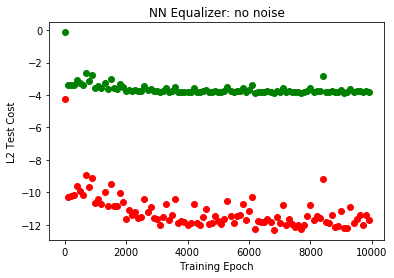

In [9]:
plt.figure()

# start the session
with tf.Session() as sess:
    #    initialize the variables
    sess.run(init_op)
    mc_losses = []
    
    for epoch in range(epochs):
        
        current_start = epoch*batch_size
        preamble_train_orig_batch = preamble_train_orig[current_start:(current_start+batch_size),:,:]
        preamble_train_cfo_batch = preamble_train_cfo[current_start:(current_start+batch_size),:,:]
        omega_train_batch = omega_train[current_start:(current_start+batch_size),:]

        _,cost,est_omega_batch, omega_cost = sess.run([optimizer, estimation_loss, est_omega, omega_loss], 
                                          feed_dict={preamble_original: preamble_train_orig_batch, 
                                                    preamble_cfo: preamble_train_cfo_batch,
                                                    omega: omega_train_batch})    

        if epoch % 100 == 0: 
            
            mc_cost, mc_omega_cost, mc_est_omega,mc_corrected = sess.run([estimation_loss, 
                                                                          omega_loss,est_omega,
                                                                          preamble_rotated], 
                                             feed_dict={preamble_original: preamble_test_orig,
                                                        preamble_cfo: preamble_test_cfo,
                                                       omega: omega_test})
            
            
#             plt.plot(epoch, mc_cost, 'bo')
#             plt.plot(epoch, zero_force_error, 'ro')
#             plt.plot(epoch, mse_error, 'go')
            print('Epoch {}, Train Cost {}, Test Cost: {}'.format(epoch, cost, mc_cost))
            plt.plot(epoch,np.log(mc_cost),'go')
            plt.plot(epoch,np.log(mc_omega_cost),'ro')
#             print('Epoch {}, Train Cost {}'.format(epoch, cost))
    
    
    plt.xlabel('Training Epoch')
    plt.ylabel('L2 Test Cost')
    plt.title('NN Equalizer: no noise')
    # plt.text(1000, .025, r'NN equalizer')
    # plt.text(0.5, .025, r'Zero Force equalizer')
    plt.show()
    
    

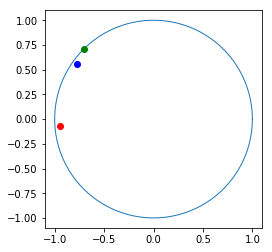

In [18]:
import numpy as np
import scipy.signal as sig
from numpy import linalg as LA
import matplotlib.pyplot as plt

plt.figure()
# plot unit circle
t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

k = 26
j = 49

# plot original point
plt.plot(preamble_test_orig[k,j,0], preamble_test_orig[k,j,1], 'go')

# plot CFO point
plt.plot(preamble_test_cfo[k,j,0], preamble_test_cfo[k,j,1], 'ro')

# plot rotated point
plt.plot(mc_corrected[k,j,0], mc_corrected[k,j,1], 'bo')

plt.gca().set_aspect('equal', adjustable='box')
plt.show()